In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from IPython.display import display, Math, Image
import os
from astropy.io import fits
import pandas as pd
import glob

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [3]:
dir = os.getcwd()
dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2\\src'

In [4]:
par_dir = os.path.dirname(dir)
par_dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2'

In [16]:
def log_likelihood(params,time,flux):
        gp.set_parameter_vector(params)
        ll = gp.log_likelihood(flux)
        return ll if np.isfinite(ll) else -np.inf

### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-30 < params[0] < 20) and (-10 < params[1] < 10) and (5 < params[2] < 7)) :
        return 0
    return -np.inf

### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

    ### MCMC ###
def run_mcmc(time,flux,gp) :
    initial = gp.get_parameter_vector()
    ndim, nwalkers = len(initial), 128
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 5000,progress=True)
    print("Finished")
    
    likelihood = gp.log_likelihood(flux)
    af = sampler.acceptance_fraction
    
    print("Mean acceptance fraction:", np.mean(af))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))
    return(sampler,likelihood)

In [17]:
def gp_building(param,time,flux,error) :
    bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
    #kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
    kernel = terms.SHOTerm(log_S0=param[0], log_Q=param[1], log_omega0=param[2],bounds=bounds)


    gp = celerite.GP(kernel,mean=np.mean(flux))
    gp.compute(time,yerr=error)
 
    print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    
    return gp

In [59]:
### DATA ###
photometry_data = {"TESS_18_19" : "/data/TESS_18_19_data.dat",
                   "TESS_18_0" : "/data/TESS_18_0_data.fits",
                   "TESS_18_1" : "/data/TESS_18_1_data.fits",
                   "TESS_18_2" : "/data/TESS_18_2_data.fits",
                   "TESS_19" : "/data/TESS_19_data.fits",
                   "TESS_20_0" : "/data/TESS_20_0_data.fits",
                   "TESS_20_1" : "/data/TESS_20_1_data.fits",
                   "TESS_21" : "/data/TESS_21_data.fits"
}

sectors_names = {
    "TESS_18_19" : ["All","Sector1","Sector2","Sector3"],
                 "TESS_18_0" : ["All"],
                 "TESS_18_1" : ["All"],
                 "TESS_18_2" : ["All"],
                 "TESS_19" : ["All"],
                 "TESS_20_0" : ["All","Sector1","Sector2"],
                 "TESS_20_1" : ["All","Sector1","Sector2"],
                 "TESS_21" : ["All","Sector1","Sector2"]
}

photometry_sectors = {
    "TESS_18_19" : {"All" : np.array([1437,1517]),
                                     "Sector1" : np.array([1437,1468]),
                                      "Sector2" : np.array([1468,1491]),
                                      "Sector3" : np.array([1491,1517])},
                      "TESS_18_0" : {"All" : np.array([1410,1437])},
                      "TESS_18_1" : {"All" : np.array([1437,1464])},
                      "TESS_18_2" : {"All" : np.array([1464,1491])},
                      "TESS_19" : {"All" : np.array([1491,1525])},
                      "TESS_20_0" : {"All" : np.array([2174,2200]),
                                     "Sector1" : np.array([2174,2186]),
                                     "Sector2" : np.array([2186,2200])},
                      "TESS_20_1" : {"All" : np.array([2200,2228]),
                                     "Sector1" : np.array([2200,2214]),
                                     "Sector2" : np.array([2214,2228])},
                      "TESS_21" : {"All" : np.array([2228,2254]),
                                     "Sector1" : np.array([2228,2242]),
                                     "Sector2" : np.array([2242,2254])}
}


In [60]:
### Params ###
initial_params = [1,2.5,5.8]
mask_dumps = np.array([])
start_dumps = np.array([1441.024,1444.026,1447.026,1450.026,1451.552,1454.588,1457.588,1460.588,1463.588,1468.379,1471.505,1474.630,1481.276,1484.401,1487.526,1491.627,1494.797,1497.922,1501.046,1504.702,1507.859,1510.984,1514.109])
end_dumps = np.array([1441.033,1444.033,1447.033,1450.033,1451.555,1454.595,1457.595,1460.595,1463.595,1468.387,1471.512,1474.637,1481.283,1484.408,1487.533,1491.634,1494.807,1497.931,1501.051,1504.705,1507.872,1510.995,1514.121])

In [61]:
### Creating dataframe ###
columns = ["Photometry","Sector","Likelihood","Log S0","Log Q","Log w0","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0","RMS"]
rows = photometry_data.keys()
df = pd.DataFrame(columns=columns)

for key in photometry_data.keys() :
    for name in sectors_names[key] :
        df2 = pd.DataFrame([[key,name],[]],columns=['Photometry','Sector'])
        df = df.append(df2.loc[0])
df.set_index(["Photometry","Sector"],inplace=True)
df.sort_index(inplace=True)
df

Likelihood Log S0 Log Q Log w0 Inc - S0 Inc + S0 Inc - Q  \
Photometry Sector                                                             
TESS_18_0  All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_18_1  All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_18_19 All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector3        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_18_2  All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_19    All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_20_0  All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_20_1  All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_21    All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   

                   Inc + Q Inc - w0 Inc + w0  RMS  
Photometry Sector                                  
TESS_18_0  All         NaN      NaN      NaN  NaN  
TESS_18_1  All         NaN      NaN      NaN  NaN  
TESS_18_19 All         NaN      NaN      NaN  NaN  
           Sector1     NaN      NaN      NaN  NaN  
           Sector2     NaN      NaN      NaN  NaN  
           Sector3     NaN      NaN      NaN  NaN  
TESS_18_2  All         NaN      NaN      NaN  NaN  
TESS_19    All         NaN      NaN      NaN  NaN  
TESS_20_0  All         NaN      NaN      NaN  NaN  
           Sector1     NaN      NaN      NaN  NaN  
           Sector2     NaN      NaN      NaN  NaN  
TESS_20_1  All         NaN      NaN      NaN  NaN  
           Sector1     NaN      NaN      NaN  NaN  
           Sector2     NaN      NaN      NaN  NaN  
TESS_21    All         NaN      NaN      NaN  NaN  
           Sector1     NaN      NaN      NaN  NaN  
           Sector2     NaN      NaN      NaN  NaN

<IPython.core.display.Javascript object>


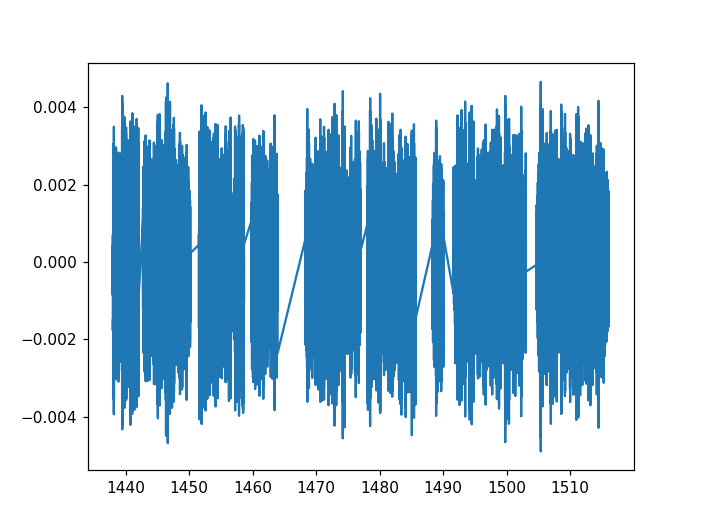

In [62]:
data = np.loadtxt(par_dir + "/data/TESS_18_19_data.dat",usecols=(0,1))
time = data[:,0]
flux = data[:,1]
plt.figure()
plt.plot(time,flux)
plt.show()

In [63]:
for photometry in photometry_data.keys() :
    file = photometry_data[photometry]
    
    for sector in photometry_sectors[photometry].keys() :
        
        print(photometry,'/',sector)
        
        if photometry == "TESS_18_19" :
            data = np.loadtxt(par_dir + file,usecols=(0,1))

            time = data[:,0]
            flux = data[:,1]
            flux_error = 4.55e-5

            for i in range(len(start_dumps)) :
                dumps_indexes = np.argwhere((time>start_dumps[i])&(time<end_dumps[i]))
                mask_dumps = np.append(mask_dumps,dumps_indexes)

            time = np.delete(time,mask_dumps.astype(int))
            flux = np.delete(flux,mask_dumps.astype(int))
            index = np.argwhere((time > photometry_sectors[photometry][sector][0]) & (time < photometry_sectors[photometry][sector][1]))
              
        else :
            hdul = fits.open(par_dir + file)
            data = hdul[1].data
            time = data['TIME']
            flux = data['PDCSAP_FLUX']
            flux_error = data['PDCSAP_FLUX_ERR']
            index = np.argwhere((~np.isnan(flux)) & (data["QUALITY"] == 0) & (time > photometry_sectors[photometry][sector][0]) & (time < photometry_sectors[photometry][sector][1]))
            time = np.ndarray.flatten(time[index])
            flux = np.ndarray.flatten(flux[index])
            flux_error = np.ndarray.flatten(flux_error[index])
            
            if photometry != "TESS_18_0" :
                for i in range(len(start_dumps)) :
                    dumps_indexes = np.argwhere((time>start_dumps[i])&(time<end_dumps[i]))
                    mask_dumps = np.append(mask_dumps,dumps_indexes)
            
            
            
            time = np.delete(time,mask_dumps.astype(int))
            flux = np.delete(flux,mask_dumps.astype(int))
            flux_error = np.delete(flux_error,mask_dumps.astype(int))
        
        
            
        gp = gp_building(initial_params,time,flux,flux_error)

        ### Minimize ###
        from scipy.optimize import minimize

        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)
        # extract our initial guess at parameters
        # from the celerite kernel and put it in a 
        # vector:
        p0 = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()

        # run optimization:
        results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
        print(results)
        print("Final log-likelihood: {0}".format(-results.fun))
        print(np.exp(results.x))
        print("Parameters: {0}".format(gp.get_parameter_dict()))
        gp.set_parameter_vector(results.x)

        sampler,likelihood = run_mcmc(time,flux,gp)
        df.loc[(photometry,sector),['Likelihood']] = likelihood
        
        ## Posteriors ###
        flat_samples = sampler.get_chain(flat=True)
        labels = ["log(S0)","log(Q)","log(w0)"]

        posteriors = np.array([])
        posteriors_errors = np.array([])
        fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
        plt.title("Posteriors_MCMC_%s_%s"%(photometry,sector))
        plt.savefig(par_dir + "/plots/%s/%s/Posteriors_MCMC_%s_%s.pdf"%(photometry,sector,photometry,sector),bbox_inches='tight')
        plt.close()  

        pred_mean, pred_var = gp.predict(flux, time, return_var=True)
        pred_std = np.sqrt(pred_var)
        
        RMS = np.sqrt(np.sum((flux - pred_mean)**2)/len(flux))
        RMS = df.loc[(photometry,sector),"RMS"]
        
        color = "#ff7f0e"
        plt.figure()
        plt.scatter(time,flux - pred_mean,s=1)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("RMS_MCMC_%s_%s"%(photometry,sector))
        plt.savefig(par_dir + "/plots/%s/%s/RMS_%s_%s.pdf"%(photometry,sector,photometry,sector),bbox_inches='tight')
        plt.close() 

        for i in range(flat_samples.shape[1]):

            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            value = np.percentile(flat_samples[:, i], [50])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
            posteriors = np.append(posteriors,value)
            posteriors_errors = np.append(posteriors_errors,q)
            
        df.loc[(photometry,sector),"Log S0":"Log w0"] = posteriors
        df.loc[(photometry,sector),"Inc - S0" : "Inc + w0"] = posteriors_errors

TESS_18_19 / All
Initial log likelihood: -145850.46368970803
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: -315003.46899063047
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-20.6171535 ,   1.18743628, -71.56049833])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 116
      nit: 12
   status: 0
  success: True
        x: array([-21.06296743,   2.15896714,   5.76448623])
Final log-likelihood: 315003.46899063047
[7.11982753e-10 8.66218617e+00 3.18775225e+02]
Parameters: OrderedDict([('kernel:log_S0', -21.06296742748433), ('kernel:log_Q', 2.1589671356692905), ('kernel:log_omega0', 5.764486240445486)])
Running burn-in...


100%|██████████| 500/500 [11:51<00:00,  1.42s/it]


Running production...


100%|██████████| 5000/5000 [1:55:12<00:00,  1.38s/it]

Finished
Mean acceptance fraction: 0.6467828124999999
parameter_dict:
OrderedDict([('kernel:log_S0', -21.065530538172816), ('kernel:log_Q', 2.2072808803766115), ('kernel:log_omega0', 5.764813030906064)])

Final MCMC log likelihood: 315002.05841031036


<IPython.core.display.Javascript object>

MemoryError: Unable to allocate 15.3 GiB for an array with shape (2050187841,) and data type float64

In [69]:
# df.to_csv(par_dir + '/data/Posteriors_photometries_new.csv')
df
# RMS = np.sqrt(np.sum((flux - pred_mean)**2)/len(flux))
print(RMS)
len(time)
for i in range(flat_samples.shape[1]):

            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            value = np.percentile(flat_samples[:, i], [50])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
            posteriors = np.append(posteriors,value)
            posteriors_errors = np.append(posteriors_errors,q)

gp.get_parameter_vector()
x = time[0:15000]
pred_mean, pred_var = gp.predict(flux, x, return_var=True)

nan


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MemoryError: Unable to allocate 5.06 GiB for an array with shape (679185000,) and data type float64

In [41]:
### Params ###
initial_params = [1,2.5,5.8]
mask_dumps = np.array([])
start_dumps = np.array([1441.024,1444.026,1447.026,1450.026,1451.552,1454.588,1457.588,1460.588,1463.588,1468.379,1471.505,1474.630,1481.276,1484.401,1487.526,1491.627,1494.797,1497.922,1501.046,1504.702,1507.859,1510.984,1514.109])
end_dumps = np.array([1441.033,1444.033,1447.033,1450.033,1451.555,1454.595,1457.595,1460.595,1463.595,1468.387,1471.512,1474.637,1481.283,1484.408,1487.533,1491.634,1494.807,1497.931,1501.051,1504.705,1507.872,1510.995,1514.121])

In [42]:
### Creating dataframe ###
columns = ["Photometry","Sector","Likelihood","Log S0","Log Q","Log w0","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0"]
rows = photometry_data.keys()
df = pd.DataFrame(columns=columns)

for key in photometry_data.keys() :
    for name in sectors_names[key] :
        df2 = pd.DataFrame([[key,name],[]],columns=['Photometry','Sector'])
        df = df.append(df2.loc[0])
df.set_index(["Photometry","Sector"],inplace=True)
df.sort_index(inplace=True)
df

Likelihood Log S0 Log Q Log w0 Inc - S0 Inc + S0 Inc - Q  \
Photometry Sector                                                             
TESS_18_19 All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector3        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_20_0  All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_20_1  All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
TESS_21    All            NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector1        NaN    NaN   NaN    NaN      NaN      NaN     NaN   
           Sector2        NaN    NaN   NaN    NaN      NaN      NaN     NaN   

                   Inc + Q Inc - w0 Inc + w0  
Photometry Sector                             
TESS_18_19 All         NaN      NaN      NaN  
           Sector1     NaN      NaN      NaN  
           Sector2     NaN      NaN      NaN  
           Sector3     NaN      NaN      NaN  
TESS_20_0  All         NaN      NaN      NaN  
           Sector1     NaN      NaN      NaN  
           Sector2     NaN      NaN      NaN  
TESS_20_1  All         NaN      NaN      NaN  
           Sector1     NaN      NaN      NaN  
           Sector2     NaN      NaN      NaN  
TESS_21    All         NaN      NaN      NaN  
           Sector1     NaN      NaN      NaN  
           Sector2     NaN      NaN      NaN

In [43]:
for photometry in photometry_data.keys() :
    file = photometry_data[photometry]
    
    for sector in photometry_sectors[photometry].keys() :
        
        print(photometry,'/',sector)
        
        if photometry == "TESS_18_19" :
            data = np.loadtxt(par_dir + file,usecols=(0,1))

            time = data[:,0]
            flux = data[:,1]
            flux_error = 4.55e-5

            for i in range(len(start_dumps)) :
                dumps_indexes = np.argwhere((time>start_dumps[i])&(time<end_dumps[i]))
                mask_dumps = np.append(mask_dumps,dumps_indexes)

            time = np.delete(time,mask_dumps.astype(int))
            flux = np.delete(flux,mask_dumps.astype(int))
            index = np.argwhere((time > photometry_sectors[photometry][sector][0]) & (time < photometry_sectors[photometry][sector][1]))
              
        else :
            hdul = fits.open(par_dir + file)
            data = hdul[1].data
            time = data['TIME']
            flux = data['PDCSAP_FLUX']
            flux_error = data['PDCSAP_FLUX_ERR']
            index = np.argwhere((~np.isnan(flux)) & (data["QUALITY"] == 0) & (time > photometry_sectors[photometry][sector][0]) & (time < photometry_sectors[photometry][sector][1]))
        
        time = np.ndarray.flatten(time[index])
        flux = np.ndarray.flatten(flux[index])
        
        if photometry != "TESS_18_19" :
            flux_error = np.ndarray.flatten(flux_error[index])
        
        gp = gp_building(initial_params,time,flux,flux_error)

        ### Minimize ###
        from scipy.optimize import minimize

        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)
        # extract our initial guess at parameters
        # from the celerite kernel and put it in a 
        # vector:
        p0 = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()

        # run optimization:
        results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
        print(results)
        print("Final log-likelihood: {0}".format(-results.fun))
        print(np.exp(results.x))
        print("Parameters: {0}".format(gp.get_parameter_dict()))
        gp.set_parameter_vector(results.x)

        sampler,likelihood = run_mcmc(time,flux,gp)
        df.loc[(photometry,sector),['Likelihood']] = likelihood
        
        ## Posteriors ###
        flat_samples = sampler.get_chain(flat=True)
        labels = ["log(S0)","log(Q)","log(w0)"]

        posteriors = np.array([])
        posteriors_errors = np.array([])
        fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
        plt.title("Posteriors_MCMC_%s_%s"%(photometry,sector))
        plt.savefig(par_dir + "/plots/%s/%s/Posteriors_MCMC_%s_%s.pdf"%(photometry,sector,photometry,sector),bbox_inches='tight')
        plt.close()  

#         x = np.linspace(np.min(time),np.max(time),15000)
#         pred_mean, pred_var = gp.predict(flux, x, return_var=True)
#         pred_std = np.sqrt(pred_var)

#         color = "#ff7f0e"
#         plt.figure()
#         plt.scatter(time,flux,s=1)
#         plt.plot(x, pred_mean, color=color)
#         plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
#         plt.xlabel("x")
#         plt.ylabel("y")
#         plt.ylim(np.min(flux),np.max(flux))
#         plt.title("Fit_MCMC_%s_%s"%(photometry,sector))
#         plt.savefig(par_dir + "/plots/%s/%s/Fit_MCMC_%s_%s.pdf"%(photometry,sector,photometry,sector),bbox_inches='tight')
#         plt.close() 

        for i in range(flat_samples.shape[1]):

            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            value = np.percentile(flat_samples[:, i], [50])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
            posteriors = np.append(posteriors,value)
            posteriors_errors = np.append(posteriors_errors,q)
            
        df.loc[(photometry,sector),"Log S0":"Log w0"] = posteriors
        df.loc[(photometry,sector),"Inc - S0" : "Inc + w0"] = posteriors_errors

TESS_18_19 / All
Initial log likelihood: -145850.46368970803
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: -315003.46899063047
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-20.6171535 ,   1.18743628, -71.56049833])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 116
      nit: 12
   status: 0
  success: True
        x: array([-21.06296743,   2.15896714,   5.76448623])
Final log-likelihood: 315003.46899063047
[7.11982753e-10 8.66218617e+00 3.18775225e+02]
Parameters: OrderedDict([('kernel:log_S0', -21.06296742748433), ('kernel:log_Q', 2.1589671356692905), ('kernel:log_omega0', 5.764486240445486)])
Running burn-in...


100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


Running production...


100%|██████████| 1000/1000 [22:44<00:00,  1.36s/it]

Finished
Mean acceptance fraction: 0.6495859375
parameter_dict:
OrderedDict([('kernel:log_S0', -21.085224948003393), ('kernel:log_Q', 2.067149464329139), ('kernel:log_omega0', 5.770092945287112)])

Final MCMC log likelihood: 314992.08876130416


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19 / Sector1
Initial log likelihood: -52306.49904855968
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: -116041.52311120051
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.75613274,  -2.8667273 , -33.29769243])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 17
   status: 0
  success: True
        x: array([-21.75039145,   2.87920815,   5.75709815])
Final log-likelihood: 116041.52311120051
[3.58034613e-10 1.78001725e+01 3.16428767e+02]
Parameters: OrderedDict([('kernel:log_S0', -21.750391448981986), ('kernel:log_Q', 2.87920814989966), ('kernel:log_omega0', 5.757098162654866)])
Running burn-in...


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Running production...


100%|██████████| 1000/1000 [08:17<00:00,  2.01it/s]

Finished
Mean acceptance fraction: 0.64578125
parameter_dict:
OrderedDict([('kernel:log_S0', -21.729403838192315), ('kernel:log_Q', 2.7579619178253005), ('kernel:log_omega0', 5.759959920388329)])

Final MCMC log likelihood: 116038.99899662571


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19 / Sector2
Initial log likelihood: -41042.65819047288
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: -88086.27385163437
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.59080776,  0.1033186 , -1.49593689])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 19
   status: 0
  success: True
        x: array([-20.88350273,   1.97381218,   5.76652249])
Final log-likelihood: 88086.27385163437
[8.51941949e-10 7.19806453e+00 3.19424994e+02]
Parameters: OrderedDict([('kernel:log_S0', -20.883502726509516), ('kernel:log_Q', 1.9738121751772453), ('kernel:log_omega0', 5.766522497010037)])
Running burn-in...


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Running production...


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]

Finished
Mean acceptance fraction: 0.6506015625000001
parameter_dict:
OrderedDict([('kernel:log_S0', -20.821809943662103), ('kernel:log_Q', 2.097372427303203), ('kernel:log_omega0', 5.755661465497101)])

Final MCMC log likelihood: 88076.57638702572


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19 / Sector3
Initial log likelihood: -52501.30645067214
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: -111594.94070477596
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.8888386 , -25.79181455,  -6.25732355])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 22
   status: 0
  success: True
        x: array([-20.61292885,   1.65510769,   5.77390361])
Final log-likelihood: 111594.94070477596
[1.11665430e-09 5.23364352e+00 3.21791434e+02]
Parameters: OrderedDict([('kernel:log_S0', -20.612928854263675), ('kernel:log_Q', 1.6551076923931272), ('kernel:log_omega0', 5.773903624238498)])
Running burn-in...


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Running production...


100%|██████████| 1000/1000 [08:17<00:00,  2.01it/s]

Finished
Mean acceptance fraction: 0.6496718750000001
parameter_dict:
OrderedDict([('kernel:log_S0', -20.630889727136385), ('kernel:log_Q', 1.6071980129355696), ('kernel:log_omega0', 5.7688342001888175)])

Final MCMC log likelihood: 111589.25202743661


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0 / All
Initial log likelihood: -2151732.7584683476
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 143880.5532743292
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  18.67010724,   13.69626261, -145.21356206])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 152
      nit: 21
   status: 0
  success: True
        x: array([8.86738614, 2.98890805, 5.74322712])
Final log-likelihood: -143880.5532743292
[7096.70687968   19.86398024  312.06987535]
Parameters: OrderedDict([('kernel:log_S0', 8.867386135668141), ('kernel:log_Q', 2.9889080533874424), ('kernel:log_omega0', 5.743227132176375)])
Running burn-in...


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Running production...


100%|██████████| 1000/1000 [09:20<00:00,  1.78it/s]

Finished
Mean acceptance fraction: 0.646953125
parameter_dict:
OrderedDict([('kernel:log_S0', 8.849304298197138), ('kernel:log_Q', 2.8354675709366437), ('kernel:log_omega0', 5.7405214093934385)])

Final MCMC log likelihood: -143885.51142425972


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0 / Sector1
Initial log likelihood: -1016620.1447162181
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 68191.04782408192
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.27794158,  2.37487257, 12.74747774])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 232
      nit: 31
   status: 0
  success: True
        x: array([8.89931037, 2.9317484 , 5.74517916])
Final log-likelihood: -68191.04782408192
[7326.91893493   18.76040245  312.67964177]
Parameters: OrderedDict([('kernel:log_S0', 8.899310370215877), ('kernel:log_Q', 2.931748395867362), ('kernel:log_omega0', 5.745179167662447)])
Running burn-in...


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Running production...


100%|██████████| 1000/1000 [04:36<00:00,  3.62it/s]

Finished
Mean acceptance fraction: 0.6473515624999999
parameter_dict:
OrderedDict([('kernel:log_S0', 8.896829739573484), ('kernel:log_Q', 2.9691423960586056), ('kernel:log_omega0', 5.743968646572923)])

Final MCMC log likelihood: -68191.13134718627


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0 / Sector2
Initial log likelihood: -1135112.613735343
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 75687.43147002767
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.94647941, 23.71089067, 36.69847501])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 164
      nit: 21
   status: 0
  success: True
        x: array([8.82108279, 3.05996046, 5.74289327])
Final log-likelihood: -75687.43147002767
[6775.59722589   21.32671387  311.9657079 ]
Parameters: OrderedDict([('kernel:log_S0', 8.821082793286331), ('kernel:log_Q', 3.0599604590696234), ('kernel:log_omega0', 5.74289328117645)])
Running burn-in...


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


Running production...


100%|██████████| 1000/1000 [05:05<00:00,  3.28it/s]

Finished
Mean acceptance fraction: 0.647859375
parameter_dict:
OrderedDict([('kernel:log_S0', 8.861892075261405), ('kernel:log_Q', 2.8556043019549815), ('kernel:log_omega0', 5.745934650690851)])

Final MCMC log likelihood: -75690.00731215431


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_1 / All
Initial log likelihood: -2256685.8824918997
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 144513.3195497188
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.57863745,  6.05650712,  2.43599061])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 240
      nit: 18
   status: 2
  success: False
        x: array([9.04543494, 2.7358764 , 5.73445644])
Final log-likelihood: -144513.3195497188
[8479.73890934   15.42325445  309.3447771 ]
Parameters: OrderedDict([('kernel:log_S0', 9.045434939318536), ('kernel:log_Q', 2.735876399462048), ('kernel:log_omega0', 5.734456448373209)])
Running burn-in...


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Running production...


100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]

Finished
Mean acceptance fraction: 0.6474296875000001
parameter_dict:
OrderedDict([('kernel:log_S0', 9.08221643789974), ('kernel:log_Q', 2.641941886735852), ('kernel:log_omega0', 5.743094754334234)])

Final MCMC log likelihood: -144527.54699323908


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_1 / Sector1
Initial log likelihood: -1104320.5986093243
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 70858.30701762644
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.22700988, 2.91620381, 0.84692147])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 336
      nit: 27
   status: 2
  success: False
        x: array([8.67631293, 3.13902918, 5.73492115])
Final log-likelihood: -70858.30701762644
[5862.39163119   23.08144809  309.48856508]
Parameters: OrderedDict([('kernel:log_S0', 8.676312927499252), ('kernel:log_Q', 3.139029182054753), ('kernel:log_omega0', 5.73492115500252)])
Running burn-in...


100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


Running production...


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]

Finished
Mean acceptance fraction: 0.6465859375
parameter_dict:
OrderedDict([('kernel:log_S0', 8.687878421427545), ('kernel:log_Q', 2.995048627233642), ('kernel:log_omega0', 5.735116805300664)])

Final MCMC log likelihood: -70859.5814327171


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_1 / Sector2
Initial log likelihood: -1152330.9918278572
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 73487.93391743113
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.84372766, -0.10477379, 45.48346624])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 112
      nit: 20
   status: 0
  success: True
        x: array([9.47425413, 2.38075085, 5.73622781])
Final log-likelihood: -73487.93391743113
[1.30201590e+04 1.08130188e+01 3.09893228e+02]
Parameters: OrderedDict([('kernel:log_S0', 9.474254130862882), ('kernel:log_Q', 2.3807508538696287), ('kernel:log_omega0', 5.736227822683435)])
Running burn-in...


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Running production...


100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]

Finished
Mean acceptance fraction: 0.6472890625000001
parameter_dict:
OrderedDict([('kernel:log_S0', 9.493642190868142), ('kernel:log_Q', 2.195933149980376), ('kernel:log_omega0', 5.732022203631599)])

Final MCMC log likelihood: -73491.5910478936


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_21 / All
Initial log likelihood: -2038702.127685298
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 144548.00123422514
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.81203494, 23.88551366, 34.10386853])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 22
   status: 0
  success: True
        x: array([10.38968587,  1.34952015,  5.76563595])
Final log-likelihood: -144548.00123422514
[3.25224492e+04 3.85557500e+00 3.19141937e+02]
Parameters: OrderedDict([('kernel:log_S0', 10.389685872978882), ('kernel:log_Q', 1.349520153576649), ('kernel:log_omega0', 5.765635958402914)])
Running burn-in...


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Running production...


100%|██████████| 1000/1000 [08:56<00:00,  1.86it/s]

Finished
Mean acceptance fraction: 0.6484375
parameter_dict:
OrderedDict([('kernel:log_S0', 10.419547501432342), ('kernel:log_Q', 1.302916453153473), ('kernel:log_omega0', 5.765569005994739)])

Final MCMC log likelihood: -144549.0506926529


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_21 / Sector1
Initial log likelihood: -1008599.432810045
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 70129.12188977783
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.24451025,  20.77576937, 211.67943487])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 116
      nit: 16
   status: 0
  success: True
        x: array([8.90315707, 2.93176724, 5.73933478])
Final log-likelihood: -70129.12188977783
[7355.15764452   18.76075607  310.85755198]
Parameters: OrderedDict([('kernel:log_S0', 8.90315706645917), ('kernel:log_Q', 2.9317672447611263), ('kernel:log_omega0', 5.739334785043784)])
Running burn-in...


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Running production...


100%|██████████| 1000/1000 [04:42<00:00,  3.55it/s]

Finished
Mean acceptance fraction: 0.648421875
parameter_dict:
OrderedDict([('kernel:log_S0', 8.991937062344897), ('kernel:log_Q', 2.642051287626022), ('kernel:log_omega0', 5.733105227269384)])

Final MCMC log likelihood: -70131.72371380684


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_21 / Sector2
Initial log likelihood: -1029869.58431141
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])

      fun: 72991.63834972067
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0509317 ,  5.43368515,  5.17611625])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 148
      nit: 23
   status: 0
  success: True
        x: array([11.08010277,  0.63807606,  5.80060651])
Final log-likelihood: -72991.63834972067
[6.48675496e+04 1.89283567e+00 3.30499951e+02]
Parameters: OrderedDict([('kernel:log_S0', 11.080102771250088), ('kernel:log_Q', 0.6380760579089203), ('kernel:log_omega0', 5.8006065210518845)])
Running burn-in...


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Running production...


100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]

Finished
Mean acceptance fraction: 0.6478046875
parameter_dict:
OrderedDict([('kernel:log_S0', 11.103686899363465), ('kernel:log_Q', 0.719399481247422), ('kernel:log_omega0', 5.796028151125107)])

Final MCMC log likelihood: -72995.58597250101


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [44]:
df.to_csv(par_dir + '/data/Posteriors_photometries.csv')
df

Likelihood     Log S0     Log Q    Log w0  Inc - S0  \
Photometry Sector                                                            
TESS_18_19 All      314992.088761 -21.058677  2.153635  5.764505  0.015221   
           Sector1  116038.998997 -21.749435  2.879153  5.757252  0.023814   
           Sector2   88076.576387 -20.881504  1.963502  5.766533  0.027494   
           Sector3  111589.252027 -20.619962  1.688584  5.774014  0.024429   
TESS_20_0  All     -143885.511424    8.85885  2.986874   5.74394  0.021936   
           Sector1  -68191.131347   8.898939  2.963332   5.74513  0.032123   
           Sector2  -75690.007312   8.823191  3.009963  5.742817  0.030002   
TESS_20_1  All     -144527.546993   9.041638  2.811244   5.73432  0.022391   
           Sector1  -70859.581433   8.674884  3.177174  5.734937  0.028486   
           Sector2  -73491.591048   9.474891  2.379316   5.73575  0.034918   
TESS_21    All     -144549.050693   10.38974  1.346802  5.765203   0.02589   
           Sector1  -70131.723714    8.92527  2.824141  5.737512  0.034233   
           Sector2  -72995.585973   11.07901  0.641044  5.800978  0.040241   

                    Inc + S0   Inc - Q   Inc + Q  Inc - w0  Inc + w0  
Photometry Sector                                                     
TESS_18_19 All      0.015264  0.031957  0.032494  0.001672  0.001673  
           Sector1  0.024734  0.071971  0.074619  0.001933  0.001961  
           Sector2  0.027086  0.053386  0.056893  0.003467  0.003497  
           Sector3  0.024434  0.041818  0.043038    0.0036  0.003608  
TESS_20_0  All      0.021974  0.072363  0.076469  0.001881  0.001831  
           Sector1  0.031621  0.105244   0.11704  0.002692  0.002706  
           Sector2  0.030536  0.100365  0.110991  0.002518  0.002476  
TESS_20_1  All      0.022433  0.068837  0.072327  0.001979  0.001983  
           Sector1   0.02874   0.10917  0.124784  0.002349  0.002359  
           Sector2  0.034852  0.080919  0.086461  0.003536  0.003476  
TESS_21    All       0.02625   0.03799  0.039516  0.004252  0.004206  
           Sector1  0.034917  0.095172  0.107094  0.002843  0.002872  
           Sector2   0.03961  0.039931  0.039465  0.008621  0.008249

<IPython.core.display.Javascript object>


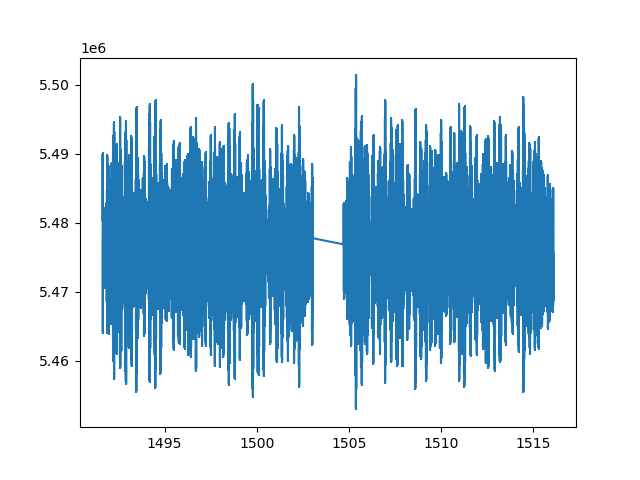

In [11]:
hdul = fits.open(par_dir + "/data/TESS_19.fits")
data = hdul[1].data
time = data['TIME']
flux = data['PDCSAP_FLUX']
flux_error = data['PDCSAP_FLUX_ERR']
index = np.argwhere((~np.isnan(flux)) & (data["QUALITY"] == 0))

time = np.ndarray.flatten(time[index])
flux = np.ndarray.flatten(flux[index])
flux_error = np.ndarray.flatten(flux_error[index])

plt.figure()
plt.errorbar(time,flux,flux_error,markersize=3,capsize=0)
plt.show()

In [7]:
files = glob.glob(par_dir+"/data/*.fits")
# file_name = os.path.basename(data[0])
# file = os.path.splitext(file_name)[0]
files

['C:\\Users\\Marc\\Documents\\repo\\stage_m2/data\\TESS_18_0_data.fits',
 'C:\\Users\\Marc\\Documents\\repo\\stage_m2/data\\TESS_18_1_data.fits',
 'C:\\Users\\Marc\\Documents\\repo\\stage_m2/data\\TESS_18_2_data.fits',
 'C:\\Users\\Marc\\Documents\\repo\\stage_m2/data\\TESS_19_data.fits',
 'C:\\Users\\Marc\\Documents\\repo\\stage_m2/data\\TESS_20_0_data.fits',
 'C:\\Users\\Marc\\Documents\\repo\\stage_m2/data\\TESS_20_1_data.fits',
 'C:\\Users\\Marc\\Documents\\repo\\stage_m2/data\\TESS_21_data.fits']

In [10]:
total_time = np.array([])
total_flux = np.array([])
total_flux_error = np.array([])

for file in files :
    hdul = fits.open(file)
    data = hdul[1].data
    time = data['TIME']
    flux = data['PDCSAP_FLUX']
    flux_error = data['PDCSAP_FLUX_ERR']
    index = np.argwhere((~np.isnan(flux)) & (data["QUALITY"] == 0))

    time = np.ndarray.flatten(time[index])
    flux_error = np.ndarray.flatten(flux_error[index])
    flux = np.ndarray.flatten(flux[index])
    
    
    total_time = np.append(total_time,time)
    total_flux = np.append(total_flux,flux)
    total_flux_error = np.append(total_flux_error,flux_error)

<IPython.core.display.Javascript object>


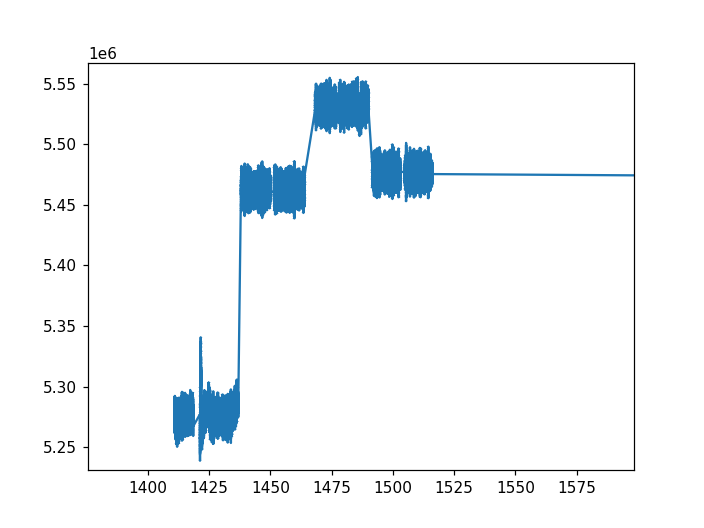

In [11]:
plt.figure()
plt.errorbar(total_time,total_flux,total_flux_error,markersize=3,capsize=0)
plt.show()